### cosine similarity + NormalScaler

Gewichten voor gebruiker 8899244: {'average_altitude_change': 0.003256593291601, 'average_distance': 0.06695833376940001, 'average_condition_value': 0.929785072938998, 'distance_to_user': 1.0}


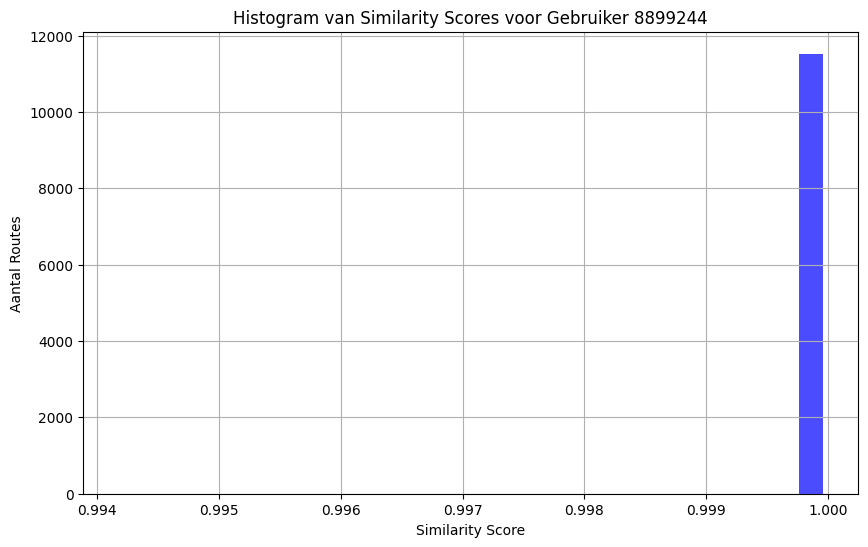

,latitude,longitude,altitude,sport,id,heart_rate,timestamp,speed,distance,altitude_change,...,average_condition_value,mean_altitude,mean_latitude,mean_longitude,orig_altitude_change,orig_distance,orig_mean_altitude,orig_average_condition_value,distance_to_user,similarity_score
4352,"[55.44989445246756, 55.44987626373768, 55.4498...","[11.562541304156184, 11.562534598633647, 11.56...","[35.8, 42.6, 35.6, 35.4, 36.0, 36.0, 35.2, 35....",run,331799033,"[70, 70, 71, 72, 75, 79, 80, 81, 82, 85, 86, 8...","[1398800962, 1398800965, 1398800969, 139880097...","[6.408, 6.408, 9.252, 10.08, 5.472, 10.296, 12...",0.047296,0.002616,...,0.079104,0.065197,55.451421,11.567167,10.0,4.876163,35.3908,0.104534,4.849071,0.999958
1073,"[55.35336778499186, 55.3534072637558, 55.35348...","[11.374538401141763, 11.374544184654951, 11.37...","[47.0, 47.2, 47.2, 46.0, 45.6, 45.2, 44.6, 44....",run,432098315,"[103, 107, 116, 123, 128, 131, 134, 138, 142, ...","[1414857346, 1414857348, 1414857351, 141485735...","[5.6772, 5.7132000000000005, 7.0236, 9.234, 11...",0.042830,0.004865,...,0.078257,0.065508,55.357093,11.386502,18.6,4.469379,37.6696,0.103506,10.751625,0.999900
1072,"[55.35341262817383, 55.35347146913409, 55.3535...","[11.374501269310713, 11.374529683962464, 11.37...","[33.6, 33.4, 33.2, 33.0, 33.0, 32.8, 32.8, 32....",run,432098322,"[118, 118, 118, 123, 127, 130, 133, 137, 138, ...","[1414861864, 1414861867, 1414861870, 141486187...","[1.8468, 5.3064, 7.4268, 8.3448, 9.4824, 10.48...",0.042737,0.003924,...,0.078257,0.065530,55.357048,11.386290,15.0,4.460908,37.8304,0.103506,10.765289,0.999900
1059,"[55.394607838243246, 55.394567772746086, 55.39...","[11.319797029718757, 11.31985486485064, 11.319...","[52.8, 52.6, 52.4, 52.0, 51.8, 51.4, 51.2, 51....",run,538852045,"[68, 73, 82, 91, 99, 104, 108, 112, 113, 116, ...","[1433816447, 1433816450, 1433816454, 143381645...","[3.0564, 5.436, 6.9588, 8.5356, 10.0656, 9.871...",0.052080,0.004238,...,0.078257,0.066588,55.393643,11.334497,16.2,5.311879,45.5932,0.103506,11.956276,0.999888
1057,"[55.394615549594164, 55.394615130499005, 55.39...","[11.319836340844631, 11.319876741617918, 11.31...","[51.2, 51.2, 51.0, 51.0, 50.8, 50.6, 50.6, 50....",run,623842455,"[79, 83, 86, 92, 97, 100, 104, 107, 112, 115, ...","[1445907880, 1445907883, 1445907886, 144590788...","[2.4768, 3.1464, 5.2272, 6.6996, 8.55, 10.0512...",0.041570,0.004918,...,0.078257,0.065883,55.398475,11.325751,18.8,4.354590,40.4180,0.103506,12.391157,0.999887
1054,"[55.394604317843914, 55.3945963550359, 55.3945...","[11.319726118817925, 11.319757383316755, 11.31...","[54.2, 54.0, 53.8, 53.6, 53.2, 53.0, 52.8, 52....",run,637053714,"[88, 90, 94, 98, 101, 105, 108, 109, 110, 111,...","[1448499204, 1448499206, 1448499209, 144849921...","[3.0708, 2.8944, 5.1624, 7.1892, 8.3844, 10.10...",0.041630,0.004865,...,0.078257,0.065962,55.398489,11.325702,18.6,4.360077,40.9972,0.103506,12.393925,0.999887
1058,"[55.39458227343857, 55.394569197669625, 55.394...","[11.319661494344473, 11.319689489901066, 11.31...","[39.2, 39.0, 39.2, 39.2, 39.2, 39.2, 39.4, 39....",run,541330319,"[74, 74, 77, 80, 81, 86, 90, 93, 97, 100, 104,...","[1434143724, 1434143725, 1434143727, 143414372...","[3.5747999999999998, 4.4964, 7.4592, 8.4168, 8...",0.021932,0.002720,...,0.078257,0.066459,55.396961,11.324281,10.4,2.565989,44.6412,0.103506,12.513330,0.999887
1023,"[55.52696336992085, 55.52696471102536, 55.5269...","[11.498612193390727, 11.498662484809756, 11.49...","[31.2, 31.2, 31.0, 31.0, 31.0, 31.0, 31.0, 31....",run,526392485,"[80, 83, 87, 90, 93, 96, 97, 101, 104, 108, 11...","[1432166397, 1432166399, 1432166401, 143216640...","[4.068, 4.428, 4.9824, 5.922, 7.524, 9.0972, 9...",0.086585,0.005441,...,0.086235,0.064189,55.525094,11.489625,20.8,8.454523,27.9976,0.113185,12.078864,0.999886
1063,"[55.3946774918586, 55.39466039277613, 55.39458...","[11.31998042576015, 11.320039769634604, 11.320...","[57.4, 58.8, 59.2, 59.2, 59.0, 58.8, 58.6, 58....",run,487810665,"[99, 99, 101, 104, 

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import folium
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Pad naar de bestanden
user_profiles_path = '../Data/Loopdata/kleinebestanden/run_gebruikersprofielen.json'
routes_path = '../Data/Loopdata/kleinebestanden/routes_volledig.json'

# Stap 1: Laad de gebruikersprofielen en routes
user_profiles_df = pd.read_json(user_profiles_path, lines=True)
routes_df = pd.read_json(routes_path, lines=True)

# Stap 2: Preprocessing van de routegegevens
routes_df['mean_altitude'] = routes_df['altitude'].apply(np.mean)
routes_df['mean_latitude'] = routes_df['latitude'].apply(np.mean)
routes_df['mean_longitude'] = routes_df['longitude'].apply(np.mean)

# Bewaar de originele waarden in aparte kolommen
user_profiles_df['orig_average_speeds'] = user_profiles_df['average_speeds']
user_profiles_df['orig_average_altitude_changes'] = user_profiles_df['average_altitude_changes']
user_profiles_df['orig_average_distances'] = user_profiles_df['average_distances']
user_profiles_df['orig_average_condition_value'] = user_profiles_df['average_condition_value']

routes_df['orig_altitude_change'] = routes_df['altitude_change']
routes_df['orig_distance'] = routes_df['distance']
routes_df['orig_mean_altitude'] = routes_df['mean_altitude']
routes_df['orig_average_condition_value'] = routes_df['average_condition_value']

# Voeg de meest voorkomende locatie van de gebruiker toe aan de DataFrame
user_profiles_df[['most_common_lat', 'most_common_lon']] = pd.DataFrame(user_profiles_df['average_location'].tolist(), index=user_profiles_df.index)

# Normaliseer de kenmerken behalve coördinaten met Min-Max schaling
scaler = MinMaxScaler()
user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']] = scaler.fit_transform(user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']])
routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']] = scaler.fit_transform(routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']])

# Stap 3: Bepaal gewichten voor gebruikerskenmerken

gewichten = {}
for index, row in user_profiles_df.iterrows():
    user_id = row['userId']
    altitude_weight = row['weight_std_altitude_change']
    distance_weight = row['weight_std_distance']
    condition_weight = row['weight_std_condition_value']
    gewichten[user_id] = {
        'average_altitude_change': altitude_weight, 
        'average_distance': distance_weight, 
        'average_condition_value': condition_weight,
        'distance_to_user': 1.0}

# Stap 4: Definieer aanbevelingsfunctie voor routes

def recommend_routes_for_user_corrected(user_id, user_profiles_df, routes_df, top_n=10):
    if user_id in gewichten:
        print(f"Gewichten voor gebruiker {user_id}: {gewichten[user_id]}")
    else:
        print(f"Geen gewichten gevonden voor gebruiker {user_id}")

    user_data = user_profiles_df[user_profiles_df['userId'] == user_id]
    user_location = (user_data['most_common_lat'].iloc[0], user_data['most_common_lon'].iloc[0])


    # Bereken de afstand tussen de gebruiker en elke route
    def calculate_distance_to_user(row):
        route_location = (row['mean_latitude'], row['mean_longitude'])
        distance_to_user = geodesic(user_location, route_location).kilometers
        return distance_to_user

    routes_df['distance_to_user'] = routes_df.apply(calculate_distance_to_user, axis=1)

    # Functie om de cosine similarity te berekenen
    def calculate_cosine_similarity(row):
        user_values = user_data[['average_altitude_changes', 'average_distances', 'average_condition_value']].values[0]
        route_values = row[['altitude_change', 'distance', 'distance_to_user', 'average_condition_value']]

        # Bereken de gewogen waarden
        gewogen_user_values = np.array([
            user_values[0] * gewichten[user_id]['average_altitude_change'],
            user_values[1] * gewichten[user_id]['average_distance'],
            user_values[2] * gewichten[user_id]['average_condition_value'],
            gewichten[user_id]['distance_to_user']])

        gewogen_route_values = np.array([
            route_values['altitude_change'],
            route_values['distance'],
            route_values['average_condition_value'],
            route_values['distance_to_user']])

        # Cosine similarity berekenen
        return cosine_similarity([gewogen_user_values], [gewogen_route_values])[0][0]


    # Pas de cosine similarity functie toe en sla de score op
    routes_df['similarity_score'] = routes_df.apply(calculate_cosine_similarity, axis=1)
# Selecteer de routes met de hoogste cosine similarity scores
    recommended_routes = routes_df.sort_values(by='similarity_score', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.hist(routes_df['similarity_score'], bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram van Similarity Scores voor Gebruiker {user_id}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Aantal Routes')
    plt.grid(True)
    plt.show()
    # Stap 5: Creëer een kaart met de locatie van de gebruiker en de routes
    user_data = user_profiles_df[user_profiles_df['userId'] == sample_user_id].iloc[0]
    user_popup_info = f"UserID: {sample_user_id}<br>" \
                    f"Average Altitude Change: {user_data['orig_average_altitude_changes']}<br>" \
                    f"Average Distance: {user_data['orig_average_distances']}<br>" \
                    f"Average Condition Value: {user_data['orig_average_condition_value']}"


    mapbox_tileset = 'https://api.mapbox.com/styles/v1/mapbox/satellite-v9/tiles/256/{z}/{x}/{y}?access_token=pk.eyJ1IjoicnVwYXR0eW4iLCJhIjoiY2xyaWU2NG9nMDd6dzJtcDhwMHp5NWV3biJ9.bHb-trK3I9Z0H2uWRSoWow'
    map_obj = folium.Map(location=user_location, zoom_start=12, tiles=mapbox_tileset, attr='Mapbox')
    folium.Marker(user_location, popup=user_popup_info).add_to(map_obj)

    # Definieer een lijst met kleuren
    colors = ["red", "blue", "green", "purple", "orange"]

    for index, route in enumerate(recommended_routes.iterrows()):
        _, route_data = route
        route_coords = list(zip(route_data['latitude'], route_data['longitude']))
        route_color = colors[index % len(colors)]
        route_popup_info = f"Route ID: {route_data['id']}<br>" \
                        f"User ID: {route_data['userId']}<br>" \
                        f"Altitude Change: {route_data['orig_altitude_change']}<br>" \
                        f"Distance: {route_data['orig_distance']}<br>" \
                        f"Condition Value: {route_data['orig_average_condition_value']}"
        folium.PolyLine(route_coords, color=route_color, weight=2.5, opacity=1, popup=route_popup_info).add_to(map_obj)

    display(map_obj) 


    return recommended_routes


# Stap 6: Test de functie voor een specifieke gebruiker

# sample_user_id = 3545637
sample_user_id = 8899244
# sample_user_id = 3537163
# sample_user_id = 5325166
recommended_routes = recommend_routes_for_user_corrected(sample_user_id, user_profiles_df, routes_df)

recommended_routes.head(10)


## andere kleur voor routes met die door de gebruiker zelf geregistreerd werden

Gewichten voor gebruiker 8899244: {'average_altitude_change': 0.003256593291601, 'average_distance': 0.06695833376940001, 'average_condition_value': 0.929785072938998, 'distance_to_user': 1.0}


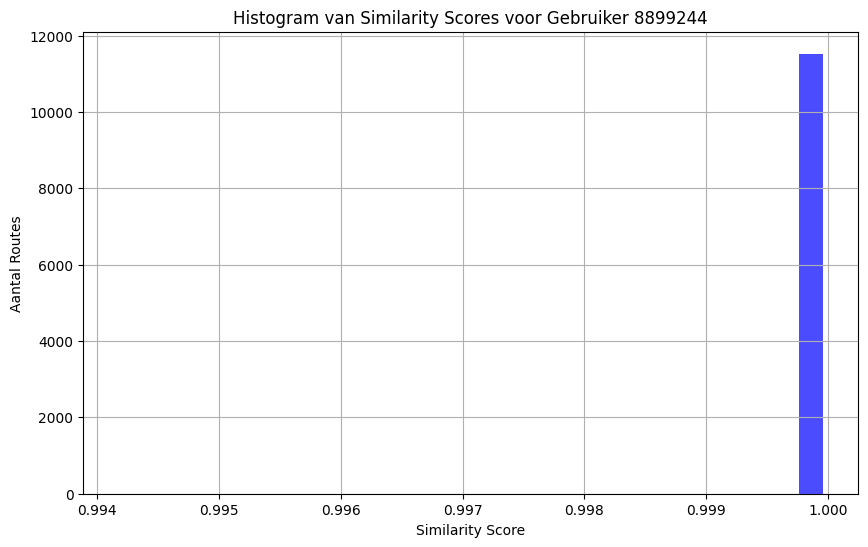

,latitude,longitude,altitude,sport,id,heart_rate,timestamp,speed,distance,altitude_change,...,average_condition_value,mean_altitude,mean_latitude,mean_longitude,orig_altitude_change,orig_distance,orig_mean_altitude,orig_average_condition_value,distance_to_user,similarity_score
4352,"[55.44989445246756, 55.44987626373768, 55.4498...","[11.562541304156184, 11.562534598633647, 11.56...","[35.8, 42.6, 35.6, 35.4, 36.0, 36.0, 35.2, 35....",run,331799033,"[70, 70, 71, 72, 75, 79, 80, 81, 82, 85, 86, 8...","[1398800962, 1398800965, 1398800969, 139880097...","[6.408, 6.408, 9.252, 10.08, 5.472, 10.296, 12...",0.047296,0.002616,...,0.079104,0.065197,55.451421,11.567167,10.0,4.876163,35.3908,0.104534,4.849071,0.999958
1073,"[55.35336778499186, 55.3534072637558, 55.35348...","[11.374538401141763, 11.374544184654951, 11.37...","[47.0, 47.2, 47.2, 46.0, 45.6, 45.2, 44.6, 44....",run,432098315,"[103, 107, 116, 123, 128, 131, 134, 138, 142, ...","[1414857346, 1414857348, 1414857351, 141485735...","[5.6772, 5.7132000000000005, 7.0236, 9.234, 11...",0.042830,0.004865,...,0.078257,0.065508,55.357093,11.386502,18.6,4.469379,37.6696,0.103506,10.751625,0.999900
1072,"[55.35341262817383, 55.35347146913409, 55.3535...","[11.374501269310713, 11.374529683962464, 11.37...","[33.6, 33.4, 33.2, 33.0, 33.0, 32.8, 32.8, 32....",run,432098322,"[118, 118, 118, 123, 127, 130, 133, 137, 138, ...","[1414861864, 1414861867, 1414861870, 141486187...","[1.8468, 5.3064, 7.4268, 8.3448, 9.4824, 10.48...",0.042737,0.003924,...,0.078257,0.065530,55.357048,11.386290,15.0,4.460908,37.8304,0.103506,10.765289,0.999900
1059,"[55.394607838243246, 55.394567772746086, 55.39...","[11.319797029718757, 11.31985486485064, 11.319...","[52.8, 52.6, 52.4, 52.0, 51.8, 51.4, 51.2, 51....",run,538852045,"[68, 73, 82, 91, 99, 104, 108, 112, 113, 116, ...","[1433816447, 1433816450, 1433816454, 143381645...","[3.0564, 5.436, 6.9588, 8.5356, 10.0656, 9.871...",0.052080,0.004238,...,0.078257,0.066588,55.393643,11.334497,16.2,5.311879,45.5932,0.103506,11.956276,0.999888
1057,"[55.394615549594164, 55.394615130499005, 55.39...","[11.319836340844631, 11.319876741617918, 11.31...","[51.2, 51.2, 51.0, 51.0, 50.8, 50.6, 50.6, 50....",run,623842455,"[79, 83, 86, 92, 97, 100, 104, 107, 112, 115, ...","[1445907880, 1445907883, 1445907886, 144590788...","[2.4768, 3.1464, 5.2272, 6.6996, 8.55, 10.0512...",0.041570,0.004918,...,0.078257,0.065883,55.398475,11.325751,18.8,4.354590,40.4180,0.103506,12.391157,0.999887
1054,"[55.394604317843914, 55.3945963550359, 55.3945...","[11.319726118817925, 11.319757383316755, 11.31...","[54.2, 54.0, 53.8, 53.6, 53.2, 53.0, 52.8, 52....",run,637053714,"[88, 90, 94, 98, 101, 105, 108, 109, 110, 111,...","[1448499204, 1448499206, 1448499209, 144849921...","[3.0708, 2.8944, 5.1624, 7.1892, 8.3844, 10.10...",0.041630,0.004865,...,0.078257,0.065962,55.398489,11.325702,18.6,4.360077,40.9972,0.103506,12.393925,0.999887
1058,"[55.39458227343857, 55.394569197669625, 55.394...","[11.319661494344473, 11.319689489901066, 11.31...","[39.2, 39.0, 39.2, 39.2, 39.2, 39.2, 39.4, 39....",run,541330319,"[74, 74, 77, 80, 81, 86, 90, 93, 97, 100, 104,...","[1434143724, 1434143725, 1434143727, 143414372...","[3.5747999999999998, 4.4964, 7.4592, 8.4168, 8...",0.021932,0.002720,...,0.078257,0.066459,55.396961,11.324281,10.4,2.565989,44.6412,0.103506,12.513330,0.999887
1023,"[55.52696336992085, 55.52696471102536, 55.5269...","[11.498612193390727, 11.498662484809756, 11.49...","[31.2, 31.2, 31.0, 31.0, 31.0, 31.0, 31.0, 31....",run,526392485,"[80, 83, 87, 90, 93, 96, 97, 101, 104, 108, 11...","[1432166397, 1432166399, 1432166401, 143216640...","[4.068, 4.428, 4.9824, 5.922, 7.524, 9.0972, 9...",0.086585,0.005441,...,0.086235,0.064189,55.525094,11.489625,20.8,8.454523,27.9976,0.113185,12.078864,0.999886
1063,"[55.3946774918586, 55.39466039277613, 55.39458...","[11.31998042576015, 11.320039769634604, 11.320...","[57.4, 58.8, 59.2, 59.2, 59.0, 58.8, 58.6, 58....",run,487810665,"[99, 99, 101, 104, 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import folium
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Pad naar de bestanden
user_profiles_path = '../Data/Loopdata/kleinebestanden/run_gebruikersprofielen.json'
routes_path = '../Data/Loopdata/kleinebestanden/routes_volledig.json'

# Laad de gebruikersprofielen en routes
user_profiles_df = pd.read_json(user_profiles_path, lines=True)
routes_df = pd.read_json(routes_path, lines=True)

# Preprocessing van de routegegevens
routes_df['mean_altitude'] = routes_df['altitude'].apply(np.mean)
routes_df['mean_latitude'] = routes_df['latitude'].apply(np.mean)
routes_df['mean_longitude'] = routes_df['longitude'].apply(np.mean)

# Bewaar de originele waarden in aparte kolommen
user_profiles_df['orig_average_speeds'] = user_profiles_df['average_speeds']
user_profiles_df['orig_average_altitude_changes'] = user_profiles_df['average_altitude_changes']
user_profiles_df['orig_average_distances'] = user_profiles_df['average_distances']
user_profiles_df['orig_average_condition_value'] = user_profiles_df['average_condition_value']

routes_df['orig_altitude_change'] = routes_df['altitude_change']
routes_df['orig_distance'] = routes_df['distance']
routes_df['orig_mean_altitude'] = routes_df['mean_altitude']
routes_df['orig_average_condition_value'] = routes_df['average_condition_value']

# Voeg de meest voorkomende locatie van de gebruiker toe aan de DataFrame
user_profiles_df[['most_common_lat', 'most_common_lon']] = pd.DataFrame(user_profiles_df['average_location'].tolist(), index=user_profiles_df.index)

# Normaliseer de kenmerken behalve coördinaten met Min-Max schaling
scaler = MinMaxScaler()
user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']] = scaler.fit_transform(user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']])
routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']] = scaler.fit_transform(routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']])

# Bepaal gewichten voor gebruikerskenmerken
gewichten = {}
for index, row in user_profiles_df.iterrows():
    user_id = row['userId']
    altitude_weight = row['weight_std_altitude_change']
    distance_weight = row['weight_std_distance']
    condition_weight = row['weight_std_condition_value']
    gewichten[user_id] = {
        'average_altitude_change': altitude_weight, 
        'average_distance': distance_weight, 
        'average_condition_value': condition_weight,
        'distance_to_user': 1.0}

# Aanbevelingsfunctie voor routes
def recommend_routes_for_user_corrected(user_id, user_profiles_df, routes_df, user_route_color='red', top_n=10):
    if user_id in gewichten:
        print(f"Gewichten voor gebruiker {user_id}: {gewichten[user_id]}")
    else:
        print(f"Geen gewichten gevonden voor gebruiker {user_id}")

    user_data = user_profiles_df[user_profiles_df['userId'] == user_id]
    user_location = (user_data['most_common_lat'].iloc[0], user_data['most_common_lon'].iloc[0])

    # Bereken de afstand tussen de gebruiker en elke route
    def calculate_distance_to_user(row):
        route_location = (row['mean_latitude'], row['mean_longitude'])
        distance_to_user = geodesic(user_location, route_location).kilometers
        return distance_to_user

    routes_df['distance_to_user'] = routes_df.apply(calculate_distance_to_user, axis=1)

    # Cosine similarity berekenen
    def calculate_cosine_similarity(row):
        user_values = user_data[['average_altitude_changes', 'average_distances', 'average_condition_value']].values[0]
        route_values = row[['altitude_change', 'distance', 'distance_to_user', 'average_condition_value']]

        # Gewogen waarden
        gewogen_user_values = np.array([
            user_values[0] * gewichten[user_id]['average_altitude_change'],
            user_values[1] * gewichten[user_id]['average_distance'],
            user_values[2] * gewichten[user_id]['average_condition_value'],
            gewichten[user_id]['distance_to_user']])

        gewogen_route_values = np.array([
            route_values['altitude_change'],
            route_values['distance'],
            route_values['average_condition_value'],
            route_values['distance_to_user']])

        return cosine_similarity([gewogen_user_values], [gewogen_route_values])[0][0]

    routes_df['similarity_score'] = routes_df.apply(calculate_cosine_similarity, axis=1)
    recommended_routes = routes_df.sort_values(by='similarity_score', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.hist(routes_df['similarity_score'], bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram van Similarity Scores voor Gebruiker {user_id}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Aantal Routes')
    plt.grid(True)
    plt.show()

    # Creëer een kaart met de locatie van de gebruiker en de routes
    mapbox_tileset = 'https://api.mapbox.com/styles/v1/mapbox/satellite-v9/tiles/256/{z}/{x}/{y}?access_token=pk.eyJ1IjoicnVwYXR0eW4iLCJhIjoiY2xyaWU2NG9nMDd6dzJtcDhwMHp5NWV3biJ9.bHb-trK3I9Z0H2uWRSoWow'
    map_obj = folium.Map(location=user_location, zoom_start=12, tiles=mapbox_tileset, attr='Mapbox')

    user_popup_info = f"UserID: {user_id}<br>" \
                    f"Average Altitude Change: {user_data['orig_average_altitude_changes']}<br>" \
                    f"Average Distance: {user_data['orig_average_distances']}<br>" \
                    f"Average Condition Value: {user_data['orig_average_condition_value']}"
    folium.Marker(user_location, popup=user_popup_info).add_to(map_obj)

    # Lijst met kleuren voor niet-gebruikersroutes
    colors = ["blue", "green", "purple", "orange"]

    for index, route in enumerate(recommended_routes.iterrows()):
        _, route_data = route
        route_coords = list(zip(route_data['latitude'], route_data['longitude']))

        # Specifieke kleur voor gebruikersroutes
        if route_data['userId'] == user_id:
            route_color = user_route_color
        else:
            route_color = colors[index % len(colors)]

        route_popup_info = f"Route ID: {route_data['id']}<br>" \
                        f"User ID: {route_data['userId']}<br>" \
                        f"Altitude Change: {route_data['orig_altitude_change']}<br>" \
                        f"Distance: {route_data['orig_distance']}<br>" \
                        f"Condition Value: {route_data['orig_average_condition_value']}"
        folium.PolyLine(route_coords, color=route_color, weight=2.5, opacity=1, popup=route_popup_info).add_to(map_obj)

    display(map_obj) 
    return recommended_routes

# Test de functie voor een specifieke gebruiker
sample_user_id = 8899244
recommended_routes = recommend_routes_for_user_corrected(sample_user_id, user_profiles_df, routes_df)
recommended_routes.head(10)


## robustscaler

Gewichten voor gebruiker 8899244: {'average_altitude_change': 0.003256593291601, 'average_distance': 0.06695833376940001, 'average_condition_value': 0.929785072938998, 'distance_to_user': 1.0}


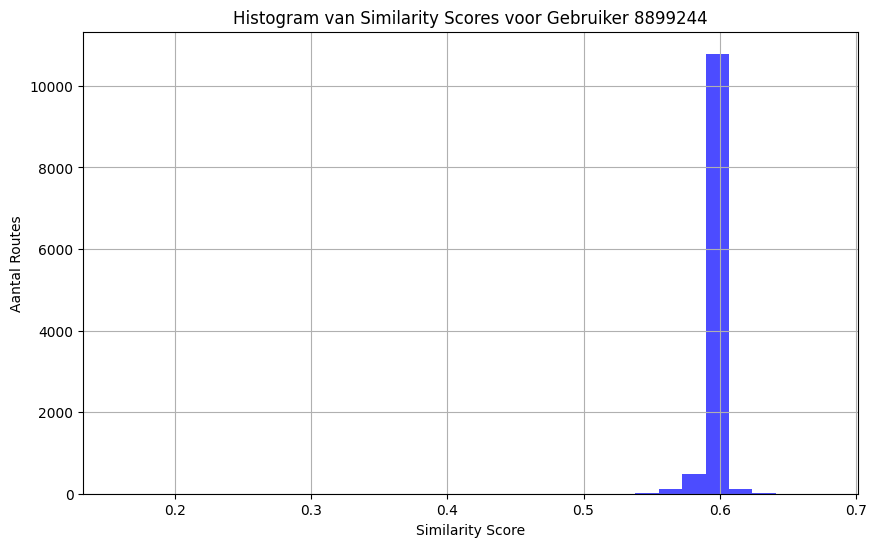

,latitude,longitude,altitude,sport,id,heart_rate,timestamp,speed,distance,altitude_change,...,average_condition_value,mean_altitude,mean_latitude,mean_longitude,orig_altitude_change,orig_distance,orig_mean_altitude,orig_average_condition_value,distance_to_user,similarity_score
4403,"[55.44029633514583, 55.440295580774546, 55.440...","[11.793413702398539, 11.793405069038272, 11.79...","[74.6, 74.2, 67.0, 59.4, 56.0, 51.8, 49.6, 49....",run,477264283,"[174, 168, 176, 180, 176, 173, 173, 171, 181, ...","[1424911411, 1424911412, 1424911414, 142491141...","[1.9656, 1.962, 4.0968, 4.0932, 4.5936, 4.8528...",-1.130125,-0.118483,...,-1.809612,-0.093115,55.436828,11.799975,34.8,3.880683,50.1724,0.019259,17.952752,0.675839
4404,"[55.44028694741428, 55.440297508612275, 55.440...","[11.793287470936775, 11.793291661888361, 11.79...","[48.2, 48.4, 48.4, 48.4, 48.2, 48.2, 48.6, 48....",run,460573864,"[180, 180, 186, 193, 193, 192, 195, 190, 195, ...","[1421627019, 1421627020, 1421627023, 142162702...","[3.492, 3.9455999999999998, 5.418, 6.519600000...",-0.923046,-0.431280,...,-1.809612,-0.129949,55.434734,11.799271,21.6,5.092268,45.2280,0.019259,17.882942,0.675786
4402,"[55.39785825647414, 55.397860100492835, 55.397...","[11.247559608891606, 11.247576707974076, 11.24...","[38.0, 37.8, 36.2, 34.2, 33.0, 31.8, 31.8, 31....",run,620414029,"[132, 132, 135, 135, 149, 146, 154, 154, 167, ...","[1445292949, 1445292950, 1445292957, 144529296...","[2.7036, 2.7684, 3.8484, 5.5044, 5.2776, 4.341...",-0.770124,0.028436,...,-1.809612,-0.365377,55.399892,11.237445,41.0,5.986988,13.6252,0.019259,17.907220,0.675686
4401,"[55.39736347272992, 55.39736439473927, 55.3973...","[11.247821794822812, 11.247834786772728, 11.24...","[-31.4, -31.4, -38.2, -40.8, -41.6, -41.8, -42...",run,627063864,"[216, 216, 212, 208, 217, 211, 214, 215, 214, ...","[1446508708, 1446508709, 1446508713, 144650872...","[2.0304, 2.0304, 4.6764, 4.8672, 4.536, 4.6044...",-0.769639,0.720379,...,-1.809612,-0.427593,55.399896,11.236863,70.2,5.989826,5.2736,0.019259,17.943801,0.674984
5627,"[55.44764081016183, 55.44772136025131, 55.4478...","[11.799882855266333, 11.79965604096651, 11.799...","[64.0, 64.2, 63.6, 63.6, 63.2, 63.4, 63.6, 63....",run,642409123,"[74, 74, 104, 126, 145, 146, 151, 158, 161, 16...","[1449712864, 1449712871, 1449712878, 144971288...","[0.6012000000000001, 5.22, 9.5868, 10.5732, 9....",0.000669,-0.180095,...,-0.995228,-0.023506,55.444665,11.802629,32.2,10.496761,59.5164,0.052102,18.240272,0.639247
5633,"[55.46100055798888, 55.46099888160825, 55.4609...","[11.803805502131581, 11.80382452905178, 11.803...","[36.0, 36.0, 37.2, 37.6, 37.8, 37.6, 37.4, 37....",run,469609906,"[94, 93, 94, 96, 99, 103, 106, 106, 108, 109, ...","[1423440645, 1423440646, 1423440649, 142344065...","[3.2688, 3.1032, 3.8772, 11.8188, 12.276, 13.0...",-0.343778,-0.407583,...,-0.995228,-0.117541,55.451516,11.806559,22.6,8.481463,46.8936,0.052102,18.622672,0.639147
5632,"[55.487806806340814, 55.48776498064399, 55.487...","[11.80237085558474, 11.802306147292256, 11.802...","[68.6, 68.8, 68.6, 69.0, 69.2, 67.8, 66.6, 67....",run,536665704,"[61, 65, 71, 80, 84, 89, 96, 102, 108, 113, 11...","[1433544152, 1433544156, 1433544160, 143354416...","[2.3256, 3.6288, 6.012, 8.4456, 9.6768, 11.008...",-0.717437,-0.336493,...,-0.995228,0.052917,55.489344,11.799828,25.6,6.295247,69.7752,0.052102,19.505272,0.638003
5630,"[55.46086451970041, 55.46087197959423, 55.4609...","[11.80458141490817, 11.804591724649072, 11.804...","[19.2, 19.2, 16.6, 16.2, 16.4, 16.8, 17.0, 16....",run,570028859,"[71, 71, 70, 67, 67, 66, 70, 79, 79, 84, 88, 8...","[1438113699, 1438113700, 1438113704, 143811370...","[2.6784, 2.8368, 5.6448, 8.4672, 8.8416, 9.838...",-0.265829,-0.426540,...,-0.995228,-0.318120,55.451676,11.819487,21.8,8.937528,19.9688,0.052102,19.428338,0.637243
5636,"[55.461443457752466, 55.46119820326567, 55.461...","[11.804323252290487, 11.804355271160603, 11.80...","[23.4, 23.4, 23.6, 23.4, 23.0, 23.0, 22.6, 22....",run,4

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from geopy.distance import geodesic
import folium
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Pad naar de bestanden
user_profiles_path = '../Data/Loopdata/kleinebestanden/run_gebruikersprofielen.json'
routes_path = '../Data/Loopdata/kleinebestanden/routes_volledig.json'

# Laad de gebruikersprofielen en routes
user_profiles_df = pd.read_json(user_profiles_path, lines=True)
routes_df = pd.read_json(routes_path, lines=True)

# Preprocessing van de routegegevens
routes_df['mean_altitude'] = routes_df['altitude'].apply(np.mean)
routes_df['mean_latitude'] = routes_df['latitude'].apply(np.mean)
routes_df['mean_longitude'] = routes_df['longitude'].apply(np.mean)

# Bewaar de originele waarden in aparte kolommen
user_profiles_df['orig_average_speeds'] = user_profiles_df['average_speeds']
user_profiles_df['orig_average_altitude_changes'] = user_profiles_df['average_altitude_changes']
user_profiles_df['orig_average_distances'] = user_profiles_df['average_distances']
user_profiles_df['orig_average_condition_value'] = user_profiles_df['average_condition_value']

routes_df['orig_altitude_change'] = routes_df['altitude_change']
routes_df['orig_distance'] = routes_df['distance']
routes_df['orig_mean_altitude'] = routes_df['mean_altitude']
routes_df['orig_average_condition_value'] = routes_df['average_condition_value']

# Voeg de meest voorkomende locatie van de gebruiker toe aan de DataFrame
user_profiles_df[['most_common_lat', 'most_common_lon']] = pd.DataFrame(user_profiles_df['average_location'].tolist(), index=user_profiles_df.index)

# Normaliseer de kenmerken behalve coördinaten met Min-Max schaling
scaler = RobustScaler()
user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']] = scaler.fit_transform(user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']])
routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']] = scaler.fit_transform(routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']])

# Bepaal gewichten voor gebruikerskenmerken
gewichten = {}
for index, row in user_profiles_df.iterrows():
    user_id = row['userId']
    altitude_weight = row['weight_std_altitude_change']
    distance_weight = row['weight_std_distance']
    condition_weight = row['weight_std_condition_value']
    gewichten[user_id] = {
        'average_altitude_change': altitude_weight, 
        'average_distance': distance_weight, 
        'average_condition_value': condition_weight,
        'distance_to_user': 1.0}

# Aanbevelingsfunctie voor routes
def recommend_routes_for_user_corrected(user_id, user_profiles_df, routes_df, user_route_color='red', top_n=10):
    if user_id in gewichten:
        print(f"Gewichten voor gebruiker {user_id}: {gewichten[user_id]}")
    else:
        print(f"Geen gewichten gevonden voor gebruiker {user_id}")

    user_data = user_profiles_df[user_profiles_df['userId'] == user_id]
    user_location = (user_data['most_common_lat'].iloc[0], user_data['most_common_lon'].iloc[0])

    # Bereken de afstand tussen de gebruiker en elke route
    def calculate_distance_to_user(row):
        route_location = (row['mean_latitude'], row['mean_longitude'])
        distance_to_user = geodesic(user_location, route_location).kilometers
        return distance_to_user

    routes_df['distance_to_user'] = routes_df.apply(calculate_distance_to_user, axis=1)

    # Cosine similarity berekenen
    def calculate_cosine_similarity(row):
        user_values = user_data[['average_altitude_changes', 'average_distances', 'average_condition_value']].values[0]
        route_values = row[['altitude_change', 'distance', 'distance_to_user', 'average_condition_value']]

        # Gewogen waarden
        gewogen_user_values = np.array([
            user_values[0] * gewichten[user_id]['average_altitude_change'],
            user_values[1] * gewichten[user_id]['average_distance'],
            user_values[2] * gewichten[user_id]['average_condition_value'],
            gewichten[user_id]['distance_to_user']])

        gewogen_route_values = np.array([
            route_values['altitude_change'],
            route_values['distance'],
            route_values['average_condition_value'],
            route_values['distance_to_user']])

        return cosine_similarity([gewogen_user_values], [gewogen_route_values])[0][0]

    routes_df['similarity_score'] = routes_df.apply(calculate_cosine_similarity, axis=1)
    recommended_routes = routes_df.sort_values(by='similarity_score', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.hist(routes_df['similarity_score'], bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram van Similarity Scores voor Gebruiker {user_id}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Aantal Routes')
    plt.grid(True)
    plt.show()

    # Creëer een kaart met de locatie van de gebruiker en de routes
    mapbox_tileset = 'https://api.mapbox.com/styles/v1/mapbox/satellite-v9/tiles/256/{z}/{x}/{y}?access_token=pk.eyJ1IjoicnVwYXR0eW4iLCJhIjoiY2xyaWU2NG9nMDd6dzJtcDhwMHp5NWV3biJ9.bHb-trK3I9Z0H2uWRSoWow'
    map_obj = folium.Map(location=user_location, zoom_start=12, tiles=mapbox_tileset, attr='Mapbox')

    user_popup_info = f"UserID: {user_id}<br>" \
                    f"Average Altitude Change: {user_data['orig_average_altitude_changes']}<br>" \
                    f"Average Distance: {user_data['orig_average_distances']}<br>" \
                    f"Average Condition Value: {user_data['orig_average_condition_value']}"
    folium.Marker(user_location, popup=user_popup_info).add_to(map_obj)

    # Lijst met kleuren voor niet-gebruikersroutes
    colors = ["blue", "green", "purple", "orange"]

    for index, route in enumerate(recommended_routes.iterrows()):
        _, route_data = route
        route_coords = list(zip(route_data['latitude'], route_data['longitude']))

        # Specifieke kleur voor gebruikersroutes
        if route_data['userId'] == user_id:
            route_color = user_route_color
        else:
            route_color = colors[index % len(colors)]

        route_popup_info = f"Route ID: {route_data['id']}<br>" \
                        f"User ID: {route_data['userId']}<br>" \
                        f"Altitude Change: {route_data['orig_altitude_change']}<br>" \
                        f"Distance: {route_data['orig_distance']}<br>" \
                        f"Condition Value: {route_data['orig_average_condition_value']}"
        folium.PolyLine(route_coords, color=route_color, weight=2.5, opacity=1, popup=route_popup_info).add_to(map_obj)

    display(map_obj) 
    return recommended_routes

# Test de functie voor een specifieke gebruiker
sample_user_id = 8899244
recommended_routes = recommend_routes_for_user_corrected(sample_user_id, user_profiles_df, routes_df)
recommended_routes.head(10)


## minmax -> average_condition_score ,rest robustscaler

Gewichten voor gebruiker 8899244: {'average_altitude_change': 0.003256593291601, 'average_distance': 0.06695833376940001, 'average_condition_value': 0.929785072938998, 'distance_to_user': 1.0}


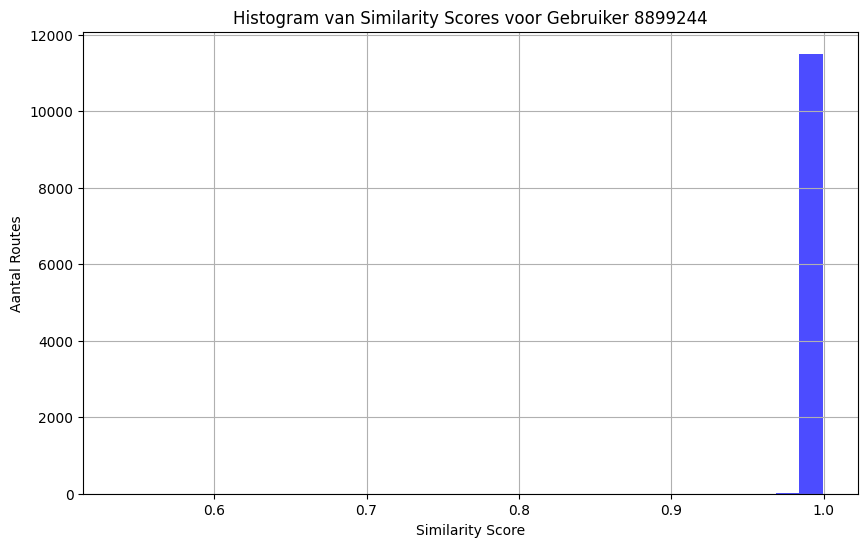

,latitude,longitude,altitude,sport,id,heart_rate,timestamp,speed,distance,altitude_change,...,average_condition_value,mean_altitude,mean_latitude,mean_longitude,orig_altitude_change,orig_distance,orig_mean_altitude,orig_average_condition_value,distance_to_user,similarity_score
4403,"[55.44029633514583, 55.440295580774546, 55.440...","[11.793413702398539, 11.793405069038272, 11.79...","[74.6, 74.2, 67.0, 59.4, 56.0, 51.8, 49.6, 49....",run,477264283,"[174, 168, 176, 180, 176, 173, 173, 171, 181, ...","[1424911411, 1424911412, 1424911414, 142491141...","[1.9656, 1.962, 4.0968, 4.0932, 4.5936, 4.8528...",-1.130125,-0.118483,...,0.019259,-0.093115,55.436828,11.799975,34.8,3.880683,50.1724,0.019259,17.952752,0.999436
1071,"[55.394649328663945, 55.39464086294174, 55.394...","[11.319836173206568, 11.319872550666332, 11.31...","[51.4, 51.2, 51.0, 50.6, 50.4, 50.0, 49.8, 49....",run,442664307,"[74, 79, 91, 101, 106, 114, 120, 123, 125, 126...","[1417220015, 1417220018, 1417220021, 141722002...","[4.2156, 7.8156, 12.186, 11.4804, 11.61, 11.11...",-0.913635,-0.393365,...,0.103506,-0.201197,55.397562,11.326417,23.2,5.147330,35.6640,0.103506,12.367879,0.999315
4353,"[55.51017710007727, 55.51016042008996, 55.5101...","[11.28480694256723, 11.284811468794942, 11.284...","[15.4, 17.6, 17.6, 15.2, 15.2, 15.0, 15.0, 15....",run,329123710,"[73, 73, 73, 74, 76, 79, 81, 86, 84, 86, 88, 9...","[1398376000, 1398376001, 1398376003, 139837600...","[10.224, 10.224, 10.224, 7.056, 9.468, 8.82, 9...",-1.319585,-0.587678,...,0.104534,-0.368091,55.505957,11.281667,15.0,2.772183,13.2608,0.104534,17.901779,0.999245
4314,"[55.50967921502888, 55.509682735428214, 55.509...","[11.299789929762483, 11.299813482910395, 11.29...","[22.2, 12.2, 12.2, 22.0, 22.6, 22.6, 22.4, 22....",run,501193788,"[76, 76, 76, 77, 77, 78, 79, 80, 79, 75, 76, 7...","[1426550767, 1426550769, 1426550771, 142655077...","[1.3679999999999999, 1.3679999999999999, 1.367...",-1.486097,-0.625592,...,0.104534,-0.313814,55.510716,11.303030,13.4,1.797954,20.5468,0.104534,17.102194,0.999240
4351,"[55.51243677735329, 55.512437112629414, 55.512...","[11.289114989340305, 11.289109205827117, 11.28...","[13.8, 17.0, 13.4, 13.4, 13.2, 12.8, 12.6, 12....",run,333204687,"[75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 78, 8...","[1398892908, 1398892909, 1398892911, 139889291...","[1.224, 1.224, 1.476, 2.628, 4.176, 4.176, 4.8...",-1.297444,-0.578199,...,0.104534,-0.393438,55.511978,11.279335,15.4,2.901729,9.8584,0.104534,18.397818,0.999232
4341,"[55.51036284305155, 55.51064128987491, 55.5105...","[11.284342166036367, 11.28400462679565, 11.283...","[-1.6, -57.2, -2.0, -2.0, -2.2, -2.0, -2.0, -2...",run,417302434,"[67, 67, 69, 70, 72, 74, 76, 78, 78, 81, 83, 8...","[1411847659, 1411847662, 1411847665, 141184766...","[19.656, 19.656, 21.636, 23.796, 23.652, 25.99...",-1.178477,0.521327,...,0.104534,-0.480202,55.507027,11.281782,61.8,3.597786,-1.7884,0.104534,17.961140,0.999169
1057,"[55.394615549594164, 55.394615130499005, 55.39...","[11.319836340844631, 11.319876741617918, 11.31...","[51.2, 51.2, 51.0, 51.0, 50.8, 50.6, 50.6, 50....",run,623842455,"[79, 83, 86, 92, 97, 100, 104, 107, 112, 115, ...","[1445907880, 1445907883, 1445907886, 144590788...","[2.4768, 3.1464, 5.2272, 6.6996, 8.55, 10.0512...",-1.049127,-0.497630,...,0.103506,-0.165782,55.398475,11.325751,18.8,4.354590,40.4180,0.103506,12.391157,0.999130
1054,"[55.394604317843914, 55.3945963550359, 55.3945...","[11.319726118817925, 11.319757383316755, 11.31...","[54.2, 54.0, 53.8, 53.6, 53.2, 53.0, 52.8, 52....",run,637053714,"[88, 90, 94, 98, 101, 105, 108, 109, 110, 111,...","[1448499204, 1448499206, 1448499209, 144849921...","[3.0708, 2.8944, 5.1624, 7.1892, 8.3844, 10.10...",-1.048189,-0.502370,...,0.103506,-0.161467,55.398489,11.325702,18.6,4.360077,40.9972,0.103506,12.393925,0.999114
1068,"[55.3946914896369, 55.39468268863857, 55.39467...","[11.319710109382868, 11.319709187373519, 11.31...","[58.8, 58.6, 58.4, 58.2, 58.0, 57.8, 57.8, 57....",run,4650400

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from geopy.distance import geodesic
import folium
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Pad naar de bestanden
user_profiles_path = '../Data/Loopdata/kleinebestanden/run_gebruikersprofielen.json'
routes_path = '../Data/Loopdata/kleinebestanden/routes_volledig.json'

# Laad de gebruikersprofielen en routes
user_profiles_df = pd.read_json(user_profiles_path, lines=True)
routes_df = pd.read_json(routes_path, lines=True)

# Preprocessing van de routegegevens
routes_df['mean_altitude'] = routes_df['altitude'].apply(np.mean)
routes_df['mean_latitude'] = routes_df['latitude'].apply(np.mean)
routes_df['mean_longitude'] = routes_df['longitude'].apply(np.mean)

# Bewaar de originele waarden in aparte kolommen
user_profiles_df['orig_average_speeds'] = user_profiles_df['average_speeds']
user_profiles_df['orig_average_altitude_changes'] = user_profiles_df['average_altitude_changes']
user_profiles_df['orig_average_distances'] = user_profiles_df['average_distances']
user_profiles_df['orig_average_condition_value'] = user_profiles_df['average_condition_value']

routes_df['orig_altitude_change'] = routes_df['altitude_change']
routes_df['orig_distance'] = routes_df['distance']
routes_df['orig_mean_altitude'] = routes_df['mean_altitude']
routes_df['orig_average_condition_value'] = routes_df['average_condition_value']

# Voeg de meest voorkomende locatie van de gebruiker toe aan de DataFrame
user_profiles_df[['most_common_lat', 'most_common_lon']] = pd.DataFrame(user_profiles_df['average_location'].tolist(), index=user_profiles_df.index)

# Normaliseer de kenmerken behalve coördinaten met Min-Max schaling
# Maak een MinMaxScaler object voor 'average_condition_score'
min_max_scaler = MinMaxScaler()
user_profiles_df['average_condition_value'] = min_max_scaler.fit_transform(user_profiles_df[['average_condition_value']])

# Maak een RobustScaler object voor de andere kenmerken van de gebruikersprofielen
robust_scaler_user_profiles = RobustScaler()
features_to_scale_user_profiles = ['average_speeds', 'average_altitude_changes', 'average_distances']
user_profiles_df[features_to_scale_user_profiles] = robust_scaler_user_profiles.fit_transform(user_profiles_df[features_to_scale_user_profiles])

# Maak een RobustScaler object voor de overeenkomstige kenmerken van de routes
robust_scaler_routes = RobustScaler()
features_to_scale_routes = ['altitude_change', 'distance', 'mean_altitude']
routes_df[features_to_scale_routes] = robust_scaler_routes.fit_transform(routes_df[features_to_scale_routes])

# Dezelfde schaling moet ook worden toegepast op de routegegevens
# routes_df[['altitude_change', 'distance', 'mean_altitude']] = robust_scaler.transform(routes_df[['altitude_change', 'distance', 'mean_altitude']])
# routes_df['average_condition_value'] = min_max_scaler.transform(routes_df[['average_condition_value']])
# Bepaal gewichten voor gebruikerskenmerken
gewichten = {}
for index, row in user_profiles_df.iterrows():
    user_id = row['userId']
    altitude_weight = row['weight_std_altitude_change']
    distance_weight = row['weight_std_distance']
    condition_weight = row['weight_std_condition_value']
    gewichten[user_id] = {
        'average_altitude_change': altitude_weight, 
        'average_distance': distance_weight, 
        'average_condition_value': condition_weight,
        'distance_to_user': 1.0}

# Aanbevelingsfunctie voor routes
def recommend_routes_for_user_corrected(user_id, user_profiles_df, routes_df, user_route_color='red', top_n=10):
    if user_id in gewichten:
        print(f"Gewichten voor gebruiker {user_id}: {gewichten[user_id]}")
    else:
        print(f"Geen gewichten gevonden voor gebruiker {user_id}")

    user_data = user_profiles_df[user_profiles_df['userId'] == user_id]
    user_location = (user_data['most_common_lat'].iloc[0], user_data['most_common_lon'].iloc[0])

    # Bereken de afstand tussen de gebruiker en elke route
    def calculate_distance_to_user(row):
        route_location = (row['mean_latitude'], row['mean_longitude'])
        distance_to_user = geodesic(user_location, route_location).kilometers
        return distance_to_user

    routes_df['distance_to_user'] = routes_df.apply(calculate_distance_to_user, axis=1)

    # Cosine similarity berekenen
    def calculate_cosine_similarity(row):
        user_values = user_data[['average_altitude_changes', 'average_distances', 'average_condition_value']].values[0]
        route_values = row[['altitude_change', 'distance', 'distance_to_user', 'average_condition_value']]

        # Gewogen waarden
        gewogen_user_values = np.array([
            user_values[0] * gewichten[user_id]['average_altitude_change'],
            user_values[1] * gewichten[user_id]['average_distance'],
            user_values[2] * gewichten[user_id]['average_condition_value'],
            gewichten[user_id]['distance_to_user']])

        gewogen_route_values = np.array([
            route_values['altitude_change'],
            route_values['distance'],
            route_values['average_condition_value'],
            route_values['distance_to_user']])

        return cosine_similarity([gewogen_user_values], [gewogen_route_values])[0][0]

    routes_df['similarity_score'] = routes_df.apply(calculate_cosine_similarity, axis=1)
    recommended_routes = routes_df.sort_values(by='similarity_score', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.hist(routes_df['similarity_score'], bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram van Similarity Scores voor Gebruiker {user_id}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Aantal Routes')
    plt.grid(True)
    plt.show()

    # Creëer een kaart met de locatie van de gebruiker en de routes
    mapbox_tileset = 'https://api.mapbox.com/styles/v1/mapbox/satellite-v9/tiles/256/{z}/{x}/{y}?access_token=pk.eyJ1IjoicnVwYXR0eW4iLCJhIjoiY2xyaWU2NG9nMDd6dzJtcDhwMHp5NWV3biJ9.bHb-trK3I9Z0H2uWRSoWow'
    map_obj = folium.Map(location=user_location, zoom_start=12, tiles=mapbox_tileset, attr='Mapbox')

    user_popup_info = f"UserID: {user_id}<br>" \
                    f"Average Altitude Change: {user_data['orig_average_altitude_changes']}<br>" \
                    f"Average Distance: {user_data['orig_average_distances']}<br>" \
                    f"Average Condition Value: {user_data['orig_average_condition_value']}"
    folium.Marker(user_location, popup=user_popup_info).add_to(map_obj)

    # Lijst met kleuren voor niet-gebruikersroutes
    colors = ["blue", "green", "purple", "orange"]

    for index, route in enumerate(recommended_routes.iterrows()):
        _, route_data = route
        route_coords = list(zip(route_data['latitude'], route_data['longitude']))

        # Specifieke kleur voor gebruikersroutes
        if route_data['userId'] == user_id:
            route_color = user_route_color
        else:
            route_color = colors[index % len(colors)]

        route_popup_info = f"Route ID: {route_data['id']}<br>" \
                        f"User ID: {route_data['userId']}<br>" \
                        f"Altitude Change: {route_data['orig_altitude_change']}<br>" \
                        f"Distance: {route_data['orig_distance']}<br>" \
                        f"Condition Value: {route_data['orig_average_condition_value']}"
        folium.PolyLine(route_coords, color=route_color, weight=2.5, opacity=1, popup=route_popup_info).add_to(map_obj)

    display(map_obj) 
    return recommended_routes

# Test de functie voor een specifieke gebruiker
sample_user_id = 8899244
recommended_routes = recommend_routes_for_user_corrected(sample_user_id, user_profiles_df, routes_df)
recommended_routes.head(10)


### cosine similarity + StandardScaler

Gewichten voor gebruiker 8899244: {'average_altitude_change': 0.003256593291601, 'average_distance': 0.06695833376940001, 'average_condition_value': 0.929785072938998, 'distance_to_user': 1.0}


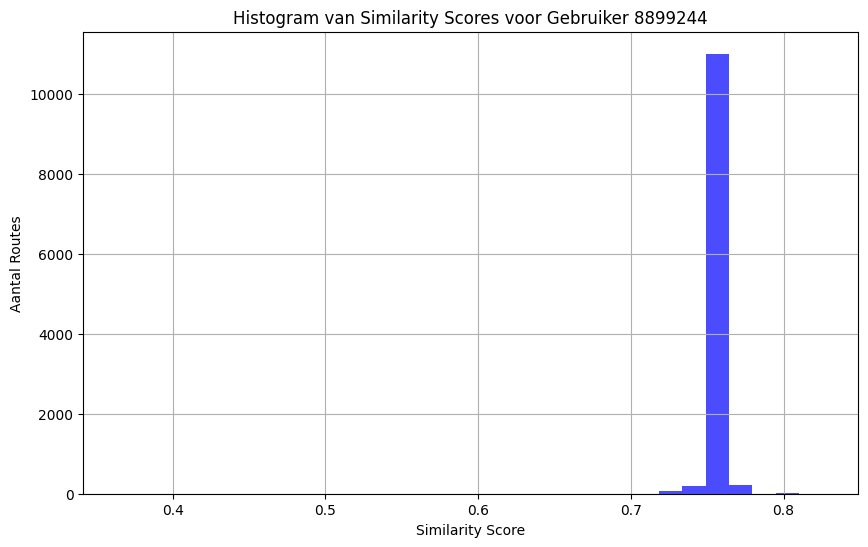

,latitude,longitude,altitude,sport,id,heart_rate,timestamp,speed,distance,altitude_change,...,average_condition_value,mean_altitude,mean_latitude,mean_longitude,orig_altitude_change,orig_distance,orig_mean_altitude,orig_average_condition_value,distance_to_user,similarity_score
4402,"[55.39785825647414, 55.397860100492835, 55.397...","[11.247559608891606, 11.247576707974076, 11.24...","[38.0, 37.8, 36.2, 34.2, 33.0, 31.8, 31.8, 31....",run,620414029,"[132, 132, 135, 135, 149, 146, 154, 154, 167, ...","[1445292949, 1445292950, 1445292957, 144529296...","[2.7036, 2.7684, 3.8484, 5.5044, 5.2776, 4.341...",-0.944096,-0.195782,...,-1.949154,-0.435732,55.399892,11.237445,41.0,5.986988,13.6252,0.019259,17.907220,0.825789
4404,"[55.44028694741428, 55.440297508612275, 55.440...","[11.793287470936775, 11.793291661888361, 11.79...","[48.2, 48.4, 48.4, 48.4, 48.2, 48.2, 48.6, 48....",run,460573864,"[180, 180, 186, 193, 193, 192, 195, 190, 195, ...","[1421627019, 1421627020, 1421627023, 142162702...","[3.492, 3.9455999999999998, 5.418, 6.519600000...",-1.085023,-0.460972,...,-1.949154,-0.334596,55.434734,11.799271,21.6,5.092268,45.2280,0.019259,17.882942,0.825769
4403,"[55.44029633514583, 55.440295580774546, 55.440...","[11.793413702398539, 11.793405069038272, 11.79...","[74.6, 74.2, 67.0, 59.4, 56.0, 51.8, 49.6, 49....",run,477264283,"[174, 168, 176, 180, 176, 173, 173, 171, 181, ...","[1424911411, 1424911412, 1424911414, 142491141...","[1.9656, 1.962, 4.0968, 4.0932, 4.5936, 4.8528...",-1.275860,-0.280533,...,-1.949154,-0.318773,55.436828,11.799975,34.8,3.880683,50.1724,0.019259,17.952752,0.825763
4401,"[55.39736347272992, 55.39736439473927, 55.3973...","[11.247821794822812, 11.247834786772728, 11.24...","[-31.4, -31.4, -38.2, -40.8, -41.6, -41.8, -42...",run,627063864,"[216, 216, 212, 208, 217, 211, 214, 215, 214, ...","[1446508708, 1446508709, 1446508713, 144650872...","[2.0304, 2.0304, 4.6764, 4.8672, 4.536, 4.6044...",-0.943649,0.203370,...,-1.949154,-0.462459,55.399896,11.236863,70.2,5.989826,5.2736,0.019259,17.943801,0.825644
5627,"[55.44764081016183, 55.44772136025131, 55.4478...","[11.799882855266333, 11.79965604096651, 11.799...","[64.0, 64.2, 63.6, 63.6, 63.2, 63.4, 63.6, 63....",run,642409123,"[74, 74, 104, 126, 145, 146, 151, 158, 161, 16...","[1449712864, 1449712871, 1449712878, 144971288...","[0.6012000000000001, 5.22, 9.5868, 10.5732, 9....",-0.233763,-0.316074,...,-1.138300,-0.288870,55.444665,11.802629,32.2,10.496761,59.5164,0.052102,18.240272,0.797554
5633,"[55.46100055798888, 55.46099888160825, 55.4609...","[11.803805502131581, 11.80382452905178, 11.803...","[36.0, 36.0, 37.2, 37.6, 37.8, 37.6, 37.4, 37....",run,469609906,"[94, 93, 94, 96, 99, 103, 106, 106, 108, 109, ...","[1423440645, 1423440646, 1423440649, 142344065...","[3.2688, 3.1032, 3.8772, 11.8188, 12.276, 13.0...",-0.551192,-0.447302,...,-1.138300,-0.329266,55.451516,11.806559,22.6,8.481463,46.8936,0.052102,18.622672,0.797409
5625,"[55.46135075390339, 55.46147011220455, 55.4616...","[11.804115129634738, 11.80398722179234, 11.803...","[-88.8, -0.2, -0.2, 0.0, -0.2, -0.4, -0.4, -0....",run,649324534,"[66, 73, 83, 97, 105, 109, 111, 118, 117, 117,...","[1451344325, 1451344331, 1451344337, 145134434...","[8.568, 5.1048, 10.0872, 11.5164, 10.9116, 11....",-0.315598,0.509568,...,-1.138300,-0.485578,55.463267,11.804129,92.6,9.977204,-1.9508,0.052102,18.778703,0.796470
5632,"[55.487806806340814, 55.48776498064399, 55.487...","[11.80237085558474, 11.802306147292256, 11.802...","[68.6, 68.8, 68.6, 69.0, 69.2, 67.8, 66.6, 67....",run,536665704,"[61, 65, 71, 80, 84, 89, 96, 102, 108, 113, 11...","[1433544152, 1433544156, 1433544160, 143354416...","[2.3256, 3.6288, 6.012, 8.4456, 9.6768, 11.008...",-0.895542,-0.406294,...,-1.138300,-0.256040,55.489344,11.799828,25.6,6.295247,69.7752,0.052102,19.505272,0.796296
5628,"[55.461136093363166, 55.461215637624264, 55.46...","[11.803786475211382, 11.80381715297699, 11.803...","[-108.6, 1.4, 0.4, 0.4, 0.6000000000000001, 0....",run

In [7]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from geopy.distance import geodesic
import folium
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Pad naar de bestanden
user_profiles_path = '../Data/Loopdata/kleinebestanden/run_gebruikersprofielen.json'
routes_path = '../Data/Loopdata/kleinebestanden/routes_volledig.json'

# Stap 1: Laad de gebruikersprofielen en routes
user_profiles_df = pd.read_json(user_profiles_path, lines=True)
routes_df = pd.read_json(routes_path, lines=True)

# Stap 2: Preprocessing van de routegegevens
routes_df['mean_altitude'] = routes_df['altitude'].apply(np.mean)
routes_df['mean_latitude'] = routes_df['latitude'].apply(np.mean)
routes_df['mean_longitude'] = routes_df['longitude'].apply(np.mean)

# Bewaar de originele waarden in aparte kolommen
user_profiles_df['orig_average_speeds'] = user_profiles_df['average_speeds']
user_profiles_df['orig_average_altitude_changes'] = user_profiles_df['average_altitude_changes']
user_profiles_df['orig_average_distances'] = user_profiles_df['average_distances']
user_profiles_df['orig_average_condition_value'] = user_profiles_df['average_condition_value']

routes_df['orig_altitude_change'] = routes_df['altitude_change']
routes_df['orig_distance'] = routes_df['distance']
routes_df['orig_mean_altitude'] = routes_df['mean_altitude']
routes_df['orig_average_condition_value'] = routes_df['average_condition_value']

# Voeg de meest voorkomende locatie van de gebruiker toe aan de DataFrame
user_profiles_df[['most_common_lat', 'most_common_lon']] = pd.DataFrame(user_profiles_df['average_location'].tolist(), index=user_profiles_df.index)

# Normaliseer de kenmerken behalve coördinaten met Min-Max schaling
scaler = StandardScaler()
user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']] = scaler.fit_transform(user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']])
routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']] = scaler.fit_transform(routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']])

# Stap 3: Bepaal gewichten voor gebruikerskenmerken

gewichten = {}
for index, row in user_profiles_df.iterrows():
    user_id = row['userId']
    altitude_weight = row['weight_std_altitude_change']
    distance_weight = row['weight_std_distance']
    condition_weight = row['weight_std_condition_value']
    gewichten[user_id] = {
        'average_altitude_change': altitude_weight, 
        'average_distance': distance_weight, 
        'average_condition_value': condition_weight,
        'distance_to_user': 1.0}

# Stap 4: Definieer aanbevelingsfunctie voor routes

def recommend_routes_for_user_corrected(user_id, user_profiles_df, routes_df, top_n=10):
    if user_id in gewichten:
        print(f"Gewichten voor gebruiker {user_id}: {gewichten[user_id]}")
    else:
        print(f"Geen gewichten gevonden voor gebruiker {user_id}")
    user_data = user_profiles_df[user_profiles_df['userId'] == user_id]
    user_location = (user_data['most_common_lat'].iloc[0], user_data['most_common_lon'].iloc[0])


    # Bereken de afstand tussen de gebruiker en elke route
    def calculate_distance_to_user(row):
        route_location = (row['mean_latitude'], row['mean_longitude'])
        distance_to_user = geodesic(user_location, route_location).kilometers
        return distance_to_user

    routes_df['distance_to_user'] = routes_df.apply(calculate_distance_to_user, axis=1)

    # Functie om de cosine similarity te berekenen
    def calculate_cosine_similarity(row):
        user_values = user_data[['average_altitude_changes', 'average_distances', 'average_condition_value']].values[0]
        route_values = row[['altitude_change', 'distance', 'distance_to_user', 'average_condition_value']]

        # Bereken de gewogen waarden
        gewogen_user_values = np.array([
            user_values[0] * gewichten[user_id]['average_altitude_change'],
            user_values[1] * gewichten[user_id]['average_distance'],
            user_values[2] * gewichten[user_id]['average_condition_value'],
            gewichten[user_id]['distance_to_user']])

        gewogen_route_values = np.array([
            route_values['altitude_change'],
            route_values['distance'],
            route_values['average_condition_value'],
            route_values['distance_to_user']])

        # Cosine similarity berekenen
        return cosine_similarity([gewogen_user_values], [gewogen_route_values])[0][0]


    # Pas de cosine similarity functie toe en sla de score op
    routes_df['similarity_score'] = routes_df.apply(calculate_cosine_similarity, axis=1)
    # Selecteer de routes met de hoogste cosine similarity scores
    recommended_routes = routes_df.sort_values(by='similarity_score', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.hist(routes_df['similarity_score'], bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram van Similarity Scores voor Gebruiker {user_id}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Aantal Routes')
    plt.grid(True)
    plt.show()
    # Stap 5: Creëer een kaart met de locatie van de gebruiker en de routes
    user_data = user_profiles_df[user_profiles_df['userId'] == sample_user_id].iloc[0]
    user_popup_info = f"UserID: {sample_user_id}<br>" \
                    f"Average Altitude Change: {user_data['orig_average_altitude_changes']}<br>" \
                    f"Average Distance: {user_data['orig_average_distances']}<br>" \
                    f"Average Condition Value: {user_data['orig_average_condition_value']}"


    mapbox_tileset = 'https://api.mapbox.com/styles/v1/mapbox/satellite-v9/tiles/256/{z}/{x}/{y}?access_token=pk.eyJ1IjoicnVwYXR0eW4iLCJhIjoiY2xyaWU2NG9nMDd6dzJtcDhwMHp5NWV3biJ9.bHb-trK3I9Z0H2uWRSoWow'
    map_obj = folium.Map(location=user_location, zoom_start=12, tiles=mapbox_tileset, attr='Mapbox')
    folium.Marker(user_location, popup=user_popup_info).add_to(map_obj)

    # Definieer een lijst met kleuren
    colors = ["red", "blue", "green", "purple", "orange"]

    for index, route in enumerate(recommended_routes.iterrows()):
        _, route_data = route
        route_coords = list(zip(route_data['latitude'], route_data['longitude']))
        route_color = colors[index % len(colors)]
        route_popup_info = f"Route ID: {route_data['id']}<br>" \
                        f"User ID: {route_data['userId']}<br>" \
                        f"Altitude Change: {route_data['orig_altitude_change']}<br>" \
                        f"Distance: {route_data['orig_distance']}<br>" \
                        f"Condition Value: {route_data['orig_average_condition_value']}"
        folium.PolyLine(route_coords, color=route_color, weight=2.5, opacity=1, popup=route_popup_info).add_to(map_obj)

    display(map_obj) 


    return recommended_routes


# Stap 6: Test de functie voor een specifieke gebruiker

# sample_user_id = 3545637
sample_user_id = 8899244
# sample_user_id = 3537163
# sample_user_id = 5325166
recommended_routes = recommend_routes_for_user_corrected(sample_user_id, user_profiles_df, routes_df)

recommended_routes.head(10)


### Strava voorbeeld

Gewichten voor gebruiker 1: {'average_altitude_change': 0.0021222902008860003, 'average_distance': 0.029820236699909002, 'average_condition_value': 0.9680574730992031, 'distance_to_user': 1.0}


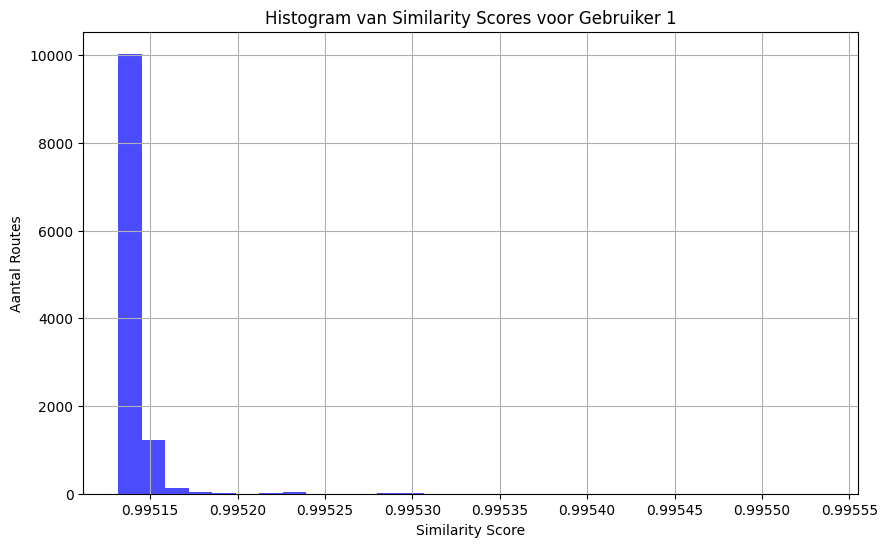

,latitude,longitude,altitude,sport,id,heart_rate,timestamp,speed,distance,altitude_change,...,average_condition_value,mean_altitude,mean_latitude,mean_longitude,orig_altitude_change,orig_distance,orig_mean_altitude,orig_average_condition_value,distance_to_user,similarity_score
188,"[50.87643471546471, 50.876434464007616, 50.876...","[3.180931331589818, 3.180923452600836, 3.18086...","[22.4, 22.4, 22.4, 22.4, 22.4, 22.4, 22.2, 21....",run,115848511,"[112, 112, 117, 119, 123, 130, 135, 140, 145, ...","[1356914815, 1356914816, 1356914818, 135691482...","[2.3508, 2.3508, 3.24, 3.7584, 5.5584, 9.9288,...",0.089052,0.007010,...,0.079041,0.064887,50.872153,3.181271,26.8,8.679252,33.1168,0.104458,19.101375,0.995535
183,"[51.030279602855444, 51.030279602855444, 51.03...","[3.041570456698537, 3.041570456698537, 3.04157...","[22.6, 22.6, 22.6, 22.6, 22.6, 22.6, 22.6, 22....",run,161909020,"[129, 129, 135, 140, 145, 153, 157, 152, 152, ...","[1361737774, 1361737775, 1361737778, 136173777...","[7.5924, 8.0028, 8.5824, 9.0432, 10.0692, 11.1...",0.103136,0.007063,...,0.079041,0.063268,51.027923,3.043416,27.0,9.962000,21.2368,0.104458,37.737548,0.995341
8208,"[50.6849929690361, 50.684992130845785, 50.6849...","[3.139309147372842, 3.139311578124761, 3.13935...","[53.8, 53.8, 53.8, 52.8, 52.0, 51.4, 50.0, 48....",run,483910620,"[80, 80, 79, 85, 91, 96, 101, 109, 114, 119, 1...","[1409703126, 1409703126, 1409703128, 140970313...","[5.0544, 5.0544, 6.5988, 12.546, 13.608, 13.95...",0.085825,0.009103,...,0.037744,0.066807,50.689004,3.129106,34.8,8.385357,47.1980,0.054359,22.335968,0.995302
8211,"[50.68452165462077, 50.68447194993496, 50.6844...","[3.139223149046302, 3.13931149430573, 3.139386...","[46.4, 46.4, 46.4, 46.4, 46.4, 46.4, 46.4, 46....",run,483910800,"[68, 74, 79, 85, 91, 97, 102, 105, 113, 112, 1...","[1407800221, 1407800225, 1407800227, 140780023...","[2.6172, 4.8852, 6.3216, 8.118, 9.5292, 10.926...",0.085785,0.006435,...,0.037744,0.067063,50.688988,3.128914,24.6,8.381691,49.0744,0.054359,22.348839,0.995302
8214,"[50.68415377289057, 50.68415377289057, 50.6841...","[3.139372514560818, 3.139372514560818, 3.13939...","[37.6, 37.6, 37.6, 37.6, 37.6, 37.6, 37.6, 38....",run,321488630,"[99, 99, 99, 101, 109, 112, 116, 122, 127, 132...","[1378561839, 1378561839, 1378561840, 137856184...","[9.8784, 7.8012, 6.0084, 5.9616, 7.02, 7.0632,...",0.085964,0.007481,...,0.037744,0.066877,50.688987,3.128770,28.6,8.397950,47.7084,0.054359,22.357950,0.995302
8209,"[50.68501451052725, 50.68501476198435, 50.6849...","[3.1396745145320892, 3.13967065885663, 3.13972...","[89.2, 89.2, 89.2, 89.2, 89.8, 90.2, 90.4, 90....",run,483910634,"[87, 87, 89, 95, 100, 105, 109, 112, 115, 120,...","[1409530918, 1409530918, 1409530922, 140953092...","[3.708, 3.384, 3.7692, 4.734, 6.0516, 7.0632, ...",0.085126,0.015171,...,0.037744,0.067299,50.689088,3.128850,58.0,8.321689,50.8056,0.054359,22.347773,0.995302
8207,"[50.6844337284565, 50.6844337284565, 50.684430...","[3.139252569526434, 3.139256089925766, 3.13927...","[29.2, 29.2, 29.2, 30.0, 31.4, 32.6, 32.8, 33....",run,483910595,"[82, 82, 82, 86, 93, 98, 99, 103, 108, 113, 11...","[1410309683, 1410309683, 1410309684, 141030968...","[2.7576, 2.7936, 2.934, 5.1444, 7.6464, 8.8596...",0.076192,0.007376,...,0.037744,0.066551,50.688754,3.128357,28.2,7.507935,45.3180,0.054359,22.395772,0.995301
8222,"[50.684467339888215, 50.684464909136295, 50.68...","[3.139238404110074, 3.139257933944463, 3.13935...","[39.8, 39.8, 39.8, 39.8, 39.8, 40.0, 40.4, 41....",run,321490224,"[87, 87, 92, 94, 107, 112, 117, 125, 130, 132,...","[1366755862, 1366755863, 1366755866, 136675586...","[3.834, 3.7296, 5.0976, 5.8932, 9.3996, 10.494...",0.101978,0.010254,...,0.037744,0.067243,50.688277,3.130745,39.2,9.856537,50.3936,0.054359,22.270405,0.995301
8221,"[50.68454470485449, 50.68447873927653, 50.6844...","[3.139119632542133, 3.139265142381191, 3.13929...","[58.4, 58.4, 58.4, 58.2, 57.6, 57.0, 57.0, 56....",run,321490169,"[82, 88, 88, 96, 101, 111, 1

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import folium
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Pad naar de bestanden
user_profiles_path = '../Data/Loopdata/kleinebestanden/run_gebruikersprofielen.json'
routes_path = '../Data/Loopdata/kleinebestanden/routes_volledig.json'

# Stap 1: Laad de gebruikersprofielen en routes
user_profiles_df = pd.read_json(user_profiles_path, lines=True)
routes_df = pd.read_json(routes_path, lines=True)

# Stap 2: Preprocessing van de routegegevens
routes_df['mean_altitude'] = routes_df['altitude'].apply(np.mean)
routes_df['mean_latitude'] = routes_df['latitude'].apply(np.mean)
routes_df['mean_longitude'] = routes_df['longitude'].apply(np.mean)

# Bewaar de originele waarden in aparte kolommen
user_profiles_df['orig_average_speeds'] = user_profiles_df['average_speeds']
user_profiles_df['orig_average_altitude_changes'] = user_profiles_df['average_altitude_changes']
user_profiles_df['orig_average_distances'] = user_profiles_df['average_distances']
user_profiles_df['orig_average_condition_value'] = user_profiles_df['average_condition_value']

routes_df['orig_altitude_change'] = routes_df['altitude_change']
routes_df['orig_distance'] = routes_df['distance']
routes_df['orig_mean_altitude'] = routes_df['mean_altitude']
routes_df['orig_average_condition_value'] = routes_df['average_condition_value']

# Voeg de meest voorkomende locatie van de gebruiker toe aan de DataFrame
user_profiles_df[['most_common_lat', 'most_common_lon']] = pd.DataFrame(user_profiles_df['average_location'].tolist(), index=user_profiles_df.index)

# Normaliseer de kenmerken behalve coördinaten met Min-Max schaling
scaler = MinMaxScaler()
user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']] = scaler.fit_transform(user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']])
routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']] = scaler.fit_transform(routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']])

# Stap 3: Bepaal gewichten voor gebruikerskenmerken

gewichten = {}
for index, row in user_profiles_df.iterrows():
    user_id = row['userId']
    altitude_weight = row['weight_std_altitude_change']
    distance_weight = row['weight_std_distance']
    condition_weight = row['weight_std_condition_value']
    gewichten[user_id] = {
        'average_altitude_change': altitude_weight, 
        'average_distance': distance_weight, 
        'average_condition_value': condition_weight,
        'distance_to_user': 1.0}

# Stap 4: Definieer aanbevelingsfunctie voor routes

def recommend_routes_for_user_corrected(user_id, user_profiles_df, routes_df, top_n=10):
    if user_id in gewichten:
        print(f"Gewichten voor gebruiker {user_id}: {gewichten[user_id]}")
    else:
        print(f"Geen gewichten gevonden voor gebruiker {user_id}")

    user_data = user_profiles_df[user_profiles_df['userId'] == user_id]
    user_location = (user_data['most_common_lat'].iloc[0], user_data['most_common_lon'].iloc[0])


    # Bereken de afstand tussen de gebruiker en elke route
    def calculate_distance_to_user(row):
        route_location = (row['mean_latitude'], row['mean_longitude'])
        distance_to_user = geodesic(user_location, route_location).kilometers
        return distance_to_user

    routes_df['distance_to_user'] = routes_df.apply(calculate_distance_to_user, axis=1)

    # Functie om de cosine similarity te berekenen
    def calculate_cosine_similarity(row):
        user_values = user_data[['average_altitude_changes', 'average_distances', 'average_condition_value']].values[0]
        route_values = row[['altitude_change', 'distance', 'distance_to_user', 'average_condition_value']]

        # Bereken de gewogen waarden
        gewogen_user_values = np.array([
            user_values[0] * gewichten[user_id]['average_altitude_change'],
            user_values[1] * gewichten[user_id]['average_distance'],
            user_values[2] * gewichten[user_id]['average_condition_value'],
            gewichten[user_id]['distance_to_user']])

        gewogen_route_values = np.array([
            route_values['altitude_change'],
            route_values['distance'],
            route_values['average_condition_value'],
            route_values['distance_to_user']])

        # Cosine similarity berekenen
        return cosine_similarity([gewogen_user_values], [gewogen_route_values])[0][0]


    # Pas de cosine similarity functie toe en sla de score op
    routes_df['similarity_score'] = routes_df.apply(calculate_cosine_similarity, axis=1)
# Selecteer de routes met de hoogste cosine similarity scores
    recommended_routes = routes_df.sort_values(by='similarity_score', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.hist(routes_df['similarity_score'], bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram van Similarity Scores voor Gebruiker {user_id}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Aantal Routes')
    plt.grid(True)
    plt.show()
    # Stap 5: Creëer een kaart met de locatie van de gebruiker en de routes
    user_data = user_profiles_df[user_profiles_df['userId'] == sample_user_id].iloc[0]
    user_popup_info = f"UserID: {sample_user_id}<br>" \
                    f"Average Altitude Change: {user_data['orig_average_altitude_changes']}<br>" \
                    f"Average Distance: {user_data['orig_average_distances']}<br>" \
                    f"Average Condition Value: {user_data['orig_average_condition_value']}"


    mapbox_tileset = 'https://api.mapbox.com/styles/v1/mapbox/satellite-v9/tiles/256/{z}/{x}/{y}?access_token=pk.eyJ1IjoicnVwYXR0eW4iLCJhIjoiY2xyaWU2NG9nMDd6dzJtcDhwMHp5NWV3biJ9.bHb-trK3I9Z0H2uWRSoWow'
    map_obj = folium.Map(location=user_location, zoom_start=12, tiles=mapbox_tileset, attr='Mapbox')
    folium.Marker(user_location, popup=user_popup_info).add_to(map_obj)

    # Definieer een lijst met kleuren
    colors = ["red", "blue", "green", "purple", "orange"]

    for index, route in enumerate(recommended_routes.iterrows()):
        _, route_data = route
        route_coords = list(zip(route_data['latitude'], route_data['longitude']))
        route_color = colors[index % len(colors)]
        route_popup_info = f"Route ID: {route_data['id']}<br>" \
                        f"User ID: {route_data['userId']}<br>" \
                        f"Altitude Change: {route_data['orig_altitude_change']}<br>" \
                        f"Distance: {route_data['orig_distance']}<br>" \
                        f"Condition Value: {route_data['orig_average_condition_value']}"
        folium.PolyLine(route_coords, color=route_color, weight=2.5, opacity=1, popup=route_popup_info).add_to(map_obj)

    display(map_obj) 


    return recommended_routes



# Stap 6: Test de functie voor een specifieke gebruiker

sample_user_id = 1
# sample_user_id = 8899244
# sample_user_id = 3537163
# sample_user_id = 5325166
recommended_routes = recommend_routes_for_user_corrected(sample_user_id, user_profiles_df, routes_df)

recommended_routes.head(10)
